# Setup


In [2]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from modules.wiki_parser import FileProcessor, WikiTextExtractor
from modules.nlp import NLP

DATA_DIR = Path().cwd() / "data"

CHINA_HEX = '#ee1c25'
RUSSIA_HEX = '#1C3578'

articles_df = pd.read_feather(DATA_DIR / "wikiarticles_seg_data.feather")
articles_df = articles_df.sample(1000)

# Drop non-substantive article sections
section_titles_to_drop = ['Early life', 'Education',
                          'External links', 'Further reading', 'References', 'See also']
articles_df = articles_df[~articles_df['title'].isin(
    section_titles_to_drop)]

# Create a combined year and month column
articles_df['month'] = articles_df['month'].astype(str).str.zfill(2)
articles_df['year_month'] = articles_df['year'].astype(str) + '-' + articles_df['month']
articles_df['year_month'] = pd.to_datetime(articles_df['year_month'])

# Embeddings


**Pretrained embeddings:** Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.


In [3]:
word_vectors = KeyedVectors.load_word2vec_format(
    DATA_DIR / "glove.840B.300d.txt", binary=False, no_header=True)

**Generating word embeddings**


In [23]:
nlp = NLP()

# Remove sections without text
articles_df.dropna(subset=['text'], inplace=True)

# Tokenize text and remove stop words
tqdm.pandas(desc="Tokenizing article text")
articles_df['tokens'] = articles_df['text'].progress_apply(
    nlp.tokenize_text)

# Generate word embeddings
articles_df['weighted_embeddings'] = nlp.generate_tfidf_weighted_embeddings(
    articles_df['tokens'], word_vectors)

# Save embeddings
articles_df.to_feather(DATA_DIR / "wikiarticles_embeddings.feather")

Generating weighted embeddings: 100%|██████████| 7791/7791 [00:23<00:00, 331.02it/s]


**Calculating pairwise cosine similarities**


In [3]:
articles_df = pd.read_feather(DATA_DIR / "wikiarticles_embeddings.feather")


def calculate_monthly_similarities(group: pd.DataFrame, figure_column: str, figure_1: str,
                                   figure_2: str, embeddings_column: str) -> float:
    """
    Calculate the cosine similarity between the monthly average embeddings of two figures.
    """
    # Filter for each figure
    figure_1_data = group[group[figure_column] == figure_1]
    figure_2_data = group[group[figure_column] == figure_2]

    # Skip if either figure is missing in this month
    if figure_1_data.empty or figure_2_data.empty:
        return np.nan

    # Use stack_embeddings to create matrices
    figure_1_embeddings = np.vstack(figure_1_data[embeddings_column])
    figure_2_embeddings = np.vstack(figure_2_data[embeddings_column])

    # Calculate similarity
    similarity_matrix = cosine_similarity(
        figure_1_embeddings, figure_2_embeddings)
    average_similarity = np.mean(similarity_matrix)

    return average_similarity


# Calculate monthly similarities
tqdm.pandas(desc="Calculating monthly similarities")
article_monthly_similarities = articles_df.groupby('year_month').progress_apply(
    calculate_monthly_similarities,
    figure_column='article_name',
    figure_1='Vladimir Putin',
    figure_2='Xi Jinping',
    embeddings_column='weighted_embeddings')

Calculating monthly similarities: 100%|██████████| 243/243 [00:00<00:00, 828.93it/s]


**Plotting cosine similarities**


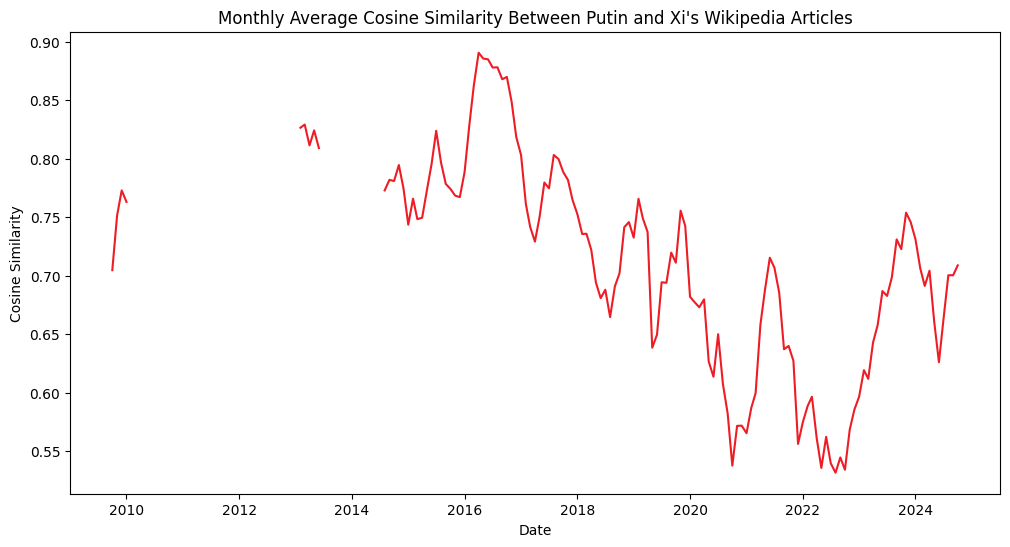

AttributeError: 'numpy.ndarray' object has no attribute 'rolling'

In [14]:
WINDOW = 6

plt.figure(figsize=(12, 6))
plt.plot(article_monthly_similarities.index,
         article_monthly_similarities.rolling(WINDOW).mean(), color=CHINA_HEX)
plt.title(
    "Monthly Average Cosine Similarity Between Putin and Xi's Wikipedia Articles")
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.show()